# Imports and configurations

Import packages

In [2]:
import yfinance as yf
import pandas as pd 
import numpy as np
import os
import pathlib
import glob
import urllib
import zipfile
import datetime as dt 
from tqdm import tqdm
import scipy
from sklearn.linear_model import LinearRegression #prediction
import pandas_datareader as web
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
import statsmodels.api as sm
import matplotlib

idx=pd.IndexSlice

Set notebooks configurations

In [3]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 60%; }
</style>
"""))

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 350)

Set paths

In [ ]:
main_folder=os.getcwd()+os.sep
main_folder 

In [622]:
if not os.path.exists('data'):
    os.makedirs('data')

In [ ]:
data_folder=os.path.join(os.getcwd(),'data')+os.sep
data_folder

# Data downloading

## FF5

Descriptions of Fama French 5 factors (2x3) can be found on Kenneth French's website.<br>
http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

Read the original FF5 data

In [624]:
ff_url = "http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"
urllib.request.urlretrieve(ff_url,'F-F_Research_Data_Factors_daily_CSV.zip')

('F-F_Research_Data_Factors_daily_CSV.zip',
 <http.client.HTTPMessage at 0x2118f259978>)

In [625]:
zip_file = zipfile.ZipFile('F-F_Research_Data_Factors_daily_CSV.zip', 'r')
zip_file.extractall()
zip_file.close()

In [626]:
ff_factors_original = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv', skiprows = 3)
ff_factors_original

,Unnamed: 0,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.00,-0.34,-0.01,0.15,0.012
1,19630702,0.79,-0.27,0.27,-0.07,-0.19,0.012
2,19630703,0.63,-0.17,-0.10,0.17,-0.33,0.012
3,19630705,0.40,0.08,-0.27,0.08,-0.33,0.012
4,19630708,-0.63,0.04,-0.19,-0.29,0.13,0.012
...,...,...,...,...,...,...,...
14595,20210624,0.68,0.70,0.23,-0.39,0.23,0.000
14596,20210625,0.32,-0.48,0.46,-0.15,0.06,0.000
14597,20210628,0.23,-0.83,-1.59,-0.45,-0.17,0.000
14598,20210629,0.01,-0.37,-0.27,0.32,0.42,0.000


In [627]:
ff_factors_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14600 entries, 0 to 14599
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  14600 non-null  int64  
 1   Mkt-RF      14600 non-null  float64
 2   SMB         14600 non-null  float64
 3   HML         14600 non-null  float64
 4   RMW         14600 non-null  float64
 5   CMA         14600 non-null  float64
 6   RF          14600 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 798.6 KB


In [628]:
ff_factors_original.rename(columns={'Unnamed: 0':'date'}, inplace=True)
ff_factors_original

,date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.00,-0.34,-0.01,0.15,0.012
1,19630702,0.79,-0.27,0.27,-0.07,-0.19,0.012
2,19630703,0.63,-0.17,-0.10,0.17,-0.33,0.012
3,19630705,0.40,0.08,-0.27,0.08,-0.33,0.012
4,19630708,-0.63,0.04,-0.19,-0.29,0.13,0.012
...,...,...,...,...,...,...,...
14595,20210624,0.68,0.70,0.23,-0.39,0.23,0.000
14596,20210625,0.32,-0.48,0.46,-0.15,0.06,0.000
14597,20210628,0.23,-0.83,-1.59,-0.45,-0.17,0.000
14598,20210629,0.01,-0.37,-0.27,0.32,0.42,0.000


In [629]:
ff_factors_original['date']=pd.to_datetime(ff_factors_original['date'], format='%Y%m%d')
ff_factors_original.set_index('date', inplace=True)
ff_factors_original

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
1963-07-01,-0.67,0.00,-0.34,-0.01,0.15,0.012
1963-07-02,0.79,-0.27,0.27,-0.07,-0.19,0.012
1963-07-03,0.63,-0.17,-0.10,0.17,-0.33,0.012
1963-07-05,0.40,0.08,-0.27,0.08,-0.33,0.012
1963-07-08,-0.63,0.04,-0.19,-0.29,0.13,0.012
...,...,...,...,...,...,...
2021-06-24,0.68,0.70,0.23,-0.39,0.23,0.000
2021-06-25,0.32,-0.48,0.46,-0.15,0.06,0.000
2021-06-28,0.23,-0.83,-1.59,-0.45,-0.17,0.000


In [630]:
ff_factors_original=ff_factors_original.div(100) #transform percentages to real numbers
ff_factors_original

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
1963-07-01,-0.0067,0.0000,-0.0034,-0.0001,0.0015,0.00012
1963-07-02,0.0079,-0.0027,0.0027,-0.0007,-0.0019,0.00012
1963-07-03,0.0063,-0.0017,-0.0010,0.0017,-0.0033,0.00012
1963-07-05,0.0040,0.0008,-0.0027,0.0008,-0.0033,0.00012
1963-07-08,-0.0063,0.0004,-0.0019,-0.0029,0.0013,0.00012
...,...,...,...,...,...,...
2021-06-24,0.0068,0.0070,0.0023,-0.0039,0.0023,0.00000
2021-06-25,0.0032,-0.0048,0.0046,-0.0015,0.0006,0.00000
2021-06-28,0.0023,-0.0083,-0.0159,-0.0045,-0.0017,0.00000


In [631]:
rf=ff_factors_original['RF'].to_frame()
rf

,RF
date,
1963-07-01,0.00012
1963-07-02,0.00012
1963-07-03,0.00012
1963-07-05,0.00012
1963-07-08,0.00012
...,...
2021-06-24,0.00000
2021-06-25,0.00000
2021-06-28,0.00000


In [632]:
ff_factors_original.drop(columns='RF', inplace=True)
ff_factors_original

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
1963-07-01,-0.0067,0.0000,-0.0034,-0.0001,0.0015
1963-07-02,0.0079,-0.0027,0.0027,-0.0007,-0.0019
1963-07-03,0.0063,-0.0017,-0.0010,0.0017,-0.0033
1963-07-05,0.0040,0.0008,-0.0027,0.0008,-0.0033
1963-07-08,-0.0063,0.0004,-0.0019,-0.0029,0.0013
...,...,...,...,...,...
2021-06-24,0.0068,0.0070,0.0023,-0.0039,0.0023
2021-06-25,0.0032,-0.0048,0.0046,-0.0015,0.0006
2021-06-28,0.0023,-0.0083,-0.0159,-0.0045,-0.0017


In [633]:
ff_factors_original.describe()

,Mkt-RF,SMB,HML,RMW,CMA
count,14600.000000,14600.000000,14600.000000,14600.000000,14600.000000
mean,0.000281,0.000081,0.000137,0.000127,0.000127
std,0.010137,0.005378,0.005559,0.003796,0.003683
min,-0.174400,-0.111700,-0.048900,-0.030200,-0.059400
25%,-0.004100,-0.002700,-0.002300,-0.001700,-0.001800
50%,0.000500,0.000200,0.000100,0.000100,0.000100
75%,0.005000,0.003000,0.002500,0.001900,0.001900
max,0.113500,0.060800,0.067000,0.044900,0.025300


<AxesSubplot:xlabel='date'>

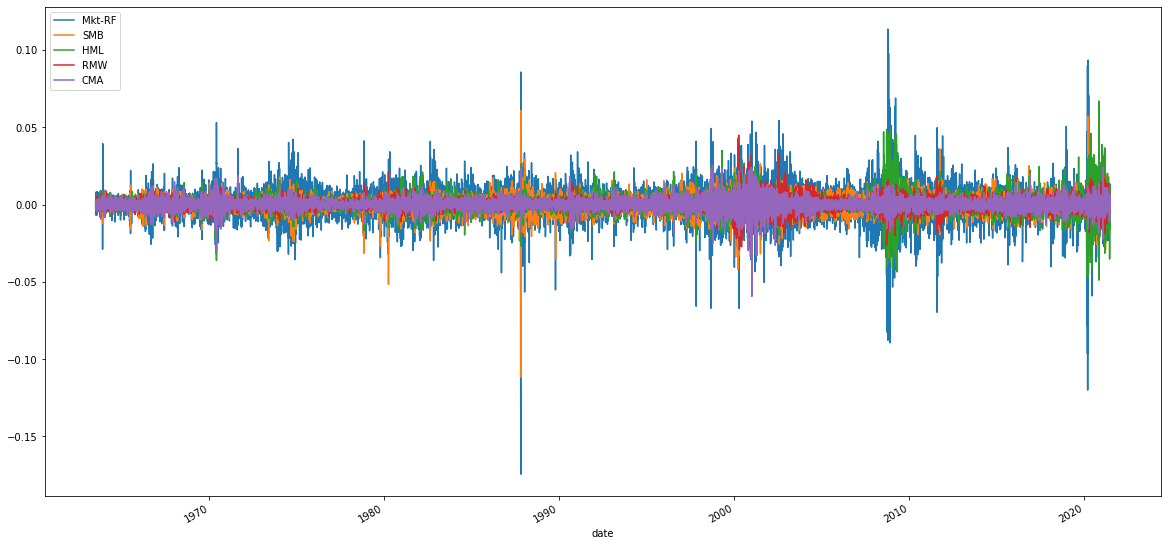

In [634]:
ff_factors_original.plot(figsize=(20,10))

<AxesSubplot:xlabel='date'>

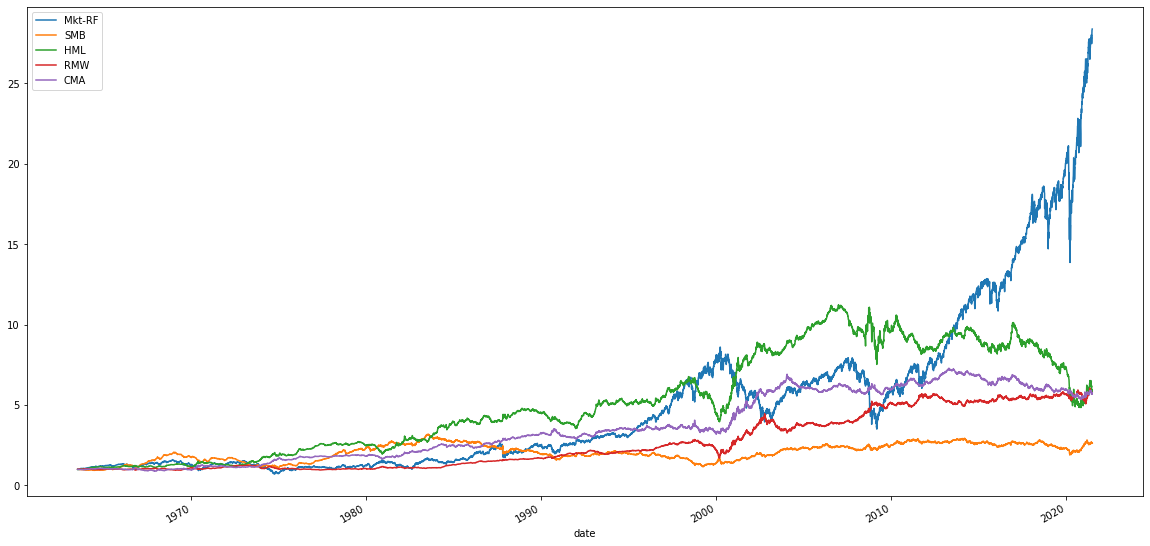

In [635]:
ff_factors_original.add(1).cumprod().plot(figsize=(20,10)) #gross returns

<AxesSubplot:ylabel='Frequency'>

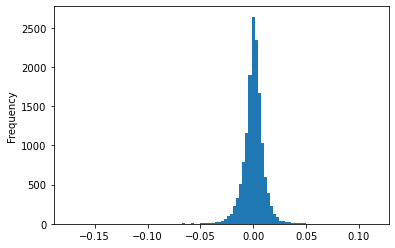

In [636]:
ff_factors_original['Mkt-RF'].plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

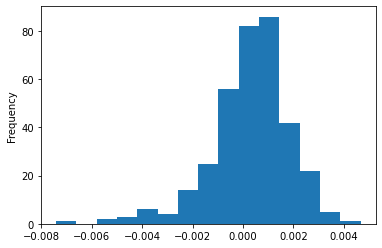

In [637]:
ff_factors_original.resample('2M').mean()['Mkt-RF'].plot(kind='hist', bins=15)

<AxesSubplot:ylabel='Density'>

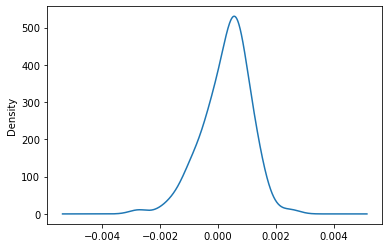

In [638]:
ff_factors_original.resample('6M').mean()['Mkt-RF'].plot(kind='density')

In [639]:
?ff_factors_original.plot

## Stocks and crypto from Yahoo Finance

Direct download from URL csv. Right-click on "download" button on yahoo finance copy URL

In [640]:
# url = "https://query1.finance.yahoo.com/v7/finance/download/DOGE-USD?period1=1594886617&period2=1626422617&interval=1d&events=history&includeAdjustedClose=true"
# file=urllib.request.urlretrieve(url,'DOGE-USD.csv')
# pd.read_csv('DOGE-USD.csv', )

Download with API

https://pypi.org/project/yfinance/

In [641]:
# if os.path.exists(os.path.join(data_folder,'findata.csv')): 
#     os.remove(foldfilename)
#     print('data already downloaded')

Example

In [642]:
# data = yf.Ticker("DOGE-USD").history(start="2017-01-01", end="2017-04-30")
# data

In [643]:
stocktick=['DOGE-USD', 'GME']
stocktick

['DOGE-USD', 'GME']

importat pagaes to understand how to work with dates
https://www.programiz.com/python-programming/datetime/strftime<br>
https://www.programiz.com/python-programming/datetime/strptime<br>
especially for the data format code

In [644]:
event_dates={'DOGE-USD':pd.Timestamp('5-8-2021'), 'GME':pd.Timestamp('22-1-2021')}
event_dates

{'DOGE-USD': Timestamp('2021-05-08 00:00:00'),
 'GME': Timestamp('2021-01-22 00:00:00')}

In [645]:
# dt.datetime.now() - pd.Timedelta('1Y 3W 3H 567M')

In [646]:
findata=pd.DataFrame()

#loop to download all stocks historical data
for ticker in tqdm(stocktick):
    stock = yf.Ticker(ticker)
    startdate=(event_dates[ticker] - pd.Timedelta('1Y')).strftime('%Y-%m-%d')
    enddate=(event_dates[ticker] + pd.Timedelta('4W')).strftime('%Y-%m-%d')
    print("downloading ticker {} from {} to {}".format(ticker, startdate, enddate))
    hist = stock.history(start=startdate, end=enddate)
    hist.loc[:,"ticker"]=ticker

    #concatenate history data of a given stock onto the financial datafram (findata)
    findata=pd.concat([findata,hist], axis=0)
findata    

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

downloading ticker DOGE-USD from 2020-05-07 to 2021-06-05


 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  2.46it/s]

downloading ticker GME from 2020-01-22 to 2021-02-19


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.82it/s]


,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2020-05-06,0.002483,0.002583,0.002473,0.002529,251393346,0,0,DOGE-USD
2020-05-07,0.002518,0.002678,0.002479,0.002664,284491226,0,0,DOGE-USD
2020-05-08,0.002659,0.002672,0.002594,0.002625,291757355,0,0,DOGE-USD
2020-05-09,0.002622,0.002634,0.002565,0.002613,294993696,0,0,DOGE-USD
2020-05-10,0.002611,0.002613,0.002360,0.002459,290801097,0,0,DOGE-USD
...,...,...,...,...,...,...,...,...
2021-02-11,50.009998,55.320000,48.220001,51.099998,13056700,0,0,GME
2021-02-12,50.750000,55.240002,48.049999,52.400002,14573300,0,0,GME
2021-02-16,52.660000,53.500000,49.040001,49.509998,8175000,0,0,GME


In [647]:
findata.set_index('ticker', append=True, inplace=True)
findata

,,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,ticker,,,,,,,
2020-05-06,DOGE-USD,0.002483,0.002583,0.002473,0.002529,251393346,0,0
2020-05-07,DOGE-USD,0.002518,0.002678,0.002479,0.002664,284491226,0,0
2020-05-08,DOGE-USD,0.002659,0.002672,0.002594,0.002625,291757355,0,0
2020-05-09,DOGE-USD,0.002622,0.002634,0.002565,0.002613,294993696,0,0
2020-05-10,DOGE-USD,0.002611,0.002613,0.002360,0.002459,290801097,0,0
...,...,...,...,...,...,...,...,...
2021-02-11,GME,50.009998,55.320000,48.220001,51.099998,13056700,0,0
2021-02-12,GME,50.750000,55.240002,48.049999,52.400002,14573300,0,0
2021-02-16,GME,52.660000,53.500000,49.040001,49.509998,8175000,0,0


# Data preparation

In [648]:
returns=findata.groupby('ticker')['Close'].pct_change(1).to_frame().rename(columns={'Close':'ret'})
returns

,,ret
Date,ticker,
2020-05-06,DOGE-USD,NaN
2020-05-07,DOGE-USD,0.053381
2020-05-08,DOGE-USD,-0.014640
2020-05-09,DOGE-USD,-0.004571
2020-05-10,DOGE-USD,-0.058936
...,...,...
2021-02-11,GME,-0.001953
2021-02-12,GME,0.025440
2021-02-16,GME,-0.055153


plot and describe the data

In [649]:
returns=findata['Close'].unstack('ticker').pct_change(1)
returns

ticker,DOGE-USD,GME
Date,,
2020-01-21,NaN,NaN
2020-01-22,NaN,-0.006536
2020-01-23,NaN,0.013158
2020-01-24,NaN,-0.064935
2020-01-27,NaN,-0.009259
...,...,...
2021-05-31,0.078041,0.000000
2021-06-01,0.135868,0.000000
2021-06-02,0.144016,0.000000


In [650]:
findata.to_csv(os.path.join(data_folder,'findata.csv'))

# Data description

In [651]:
DOGE=returns['DOGE-USD'].dropna()
GME=returns['GME'].dropna()

In [652]:
DOGE.describe()

count    394.000000
mean       0.022058
std        0.181454
min       -0.402570
25%       -0.023725
50%        0.000155
75%        0.020214
max        2.756432
Name: DOGE-USD, dtype: float64

<AxesSubplot:ylabel='Frequency'>

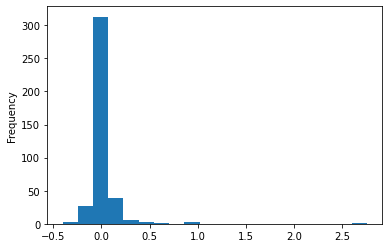

In [653]:
DOGE.plot(kind='hist', bins=20)

<AxesSubplot:ylabel='Frequency'>

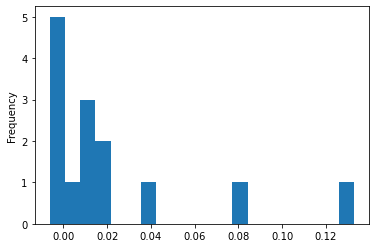

In [654]:
DOGE.resample('M').mean().plot(kind='hist', bins=20)

<AxesSubplot:ylabel='Density'>

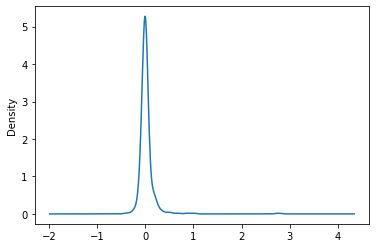

In [655]:
DOGE.plot(kind='density')

In [656]:
GME.describe()

count    468.000000
mean       0.010118
std        0.114705
min       -0.600000
25%       -0.009672
50%        0.000000
75%        0.013193
max        1.348358
Name: GME, dtype: float64

<AxesSubplot:ylabel='Density'>

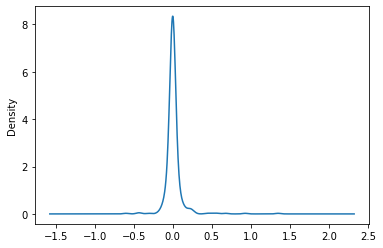

In [657]:
GME.plot(kind='density')

<AxesSubplot:ylabel='Frequency'>

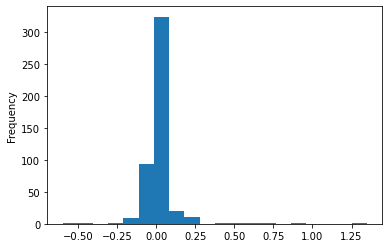

In [658]:
GME.plot(kind='hist', bins=20)

<AxesSubplot:ylabel='Frequency'>

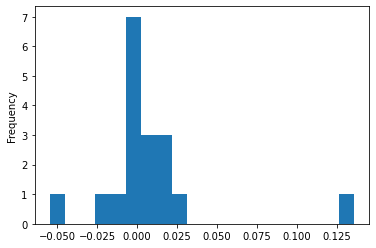

In [659]:
GME.resample('M').mean().plot(kind='hist', bins=20)

# Empirical tests

## Weak-form EMH

### Test 1 - returns follow a white noise

**Part1 Identical Distribution test- H0 returns are normally distributed - Shapiro-Wilk test**

Shapiro-Wilk test for normality<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html<br>

Alternatives:<br>
Kolmogor-Smirnov<br>
https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.kstest_normal.html

In [660]:
scipy.stats.shapiro(returns['DOGE-USD'].dropna())

ShapiroResult(statistic=0.40413326025009155, pvalue=5.62377206337766e-34)

H0 of normality rejected

In [661]:
scipy.stats.shapiro(returns['GME'].dropna())

ShapiroResult(statistic=0.5050358176231384, pvalue=4.3304472608549e-34)

H0 of normality rejected

**Part2 Autocorrelation test- H0 returns are independently distributed - Ljung-Box test**
The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process). Indedendency implies absence of correlation.

In [662]:
sm.stats.acorr_ljungbox(DOGE, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,10.241086,0.419603


H0 of independent returns cannot be rejected

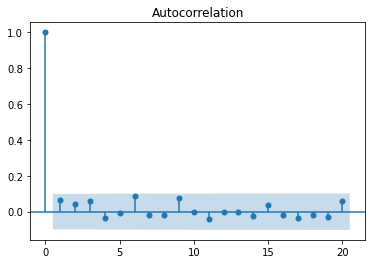

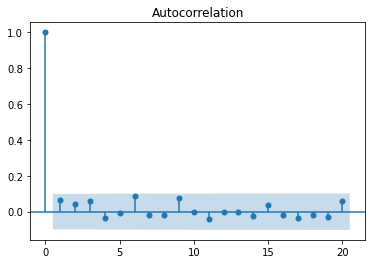

In [663]:
sm.graphics.tsa.plot_acf(DOGE, lags=20)

In [664]:
sm.stats.acorr_ljungbox(GME, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,64.533171,4.978138e-10


H0 of independent returns cannot be rejected

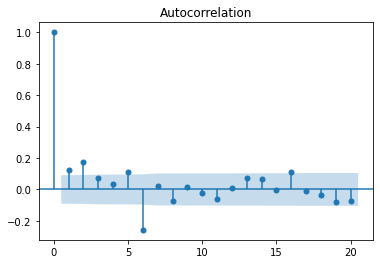

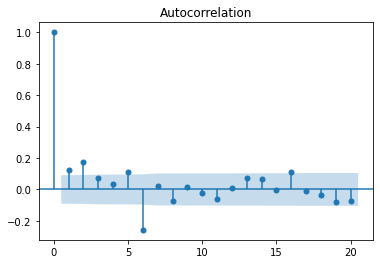

In [665]:
sm.graphics.tsa.plot_acf(GME, lags=20)

H0 of independent returns cannot be rejected

### Test 2 - test for Random Walk

Test whether the prices follow a random walk

In [666]:
DOGE_p=findata['Close'].unstack()['DOGE-USD'].dropna()
GME_p=findata['Close'].unstack()['GME'].dropna()

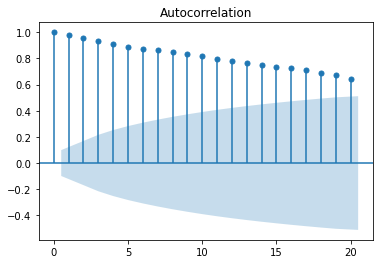

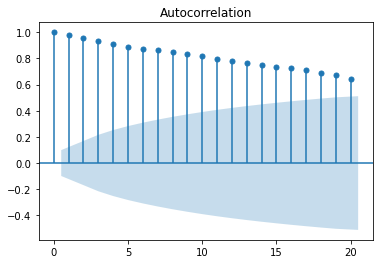

In [667]:
sm.graphics.tsa.plot_acf(DOGE_p, lags=20)

P0=10 because i cannot forecast the return (returns ~ white noise) then, the best forecast I can have for P1 is 10, I can forecast price because I cannot forecast returns
P1=10 the best forecast for today is yeasterday price (Random walk)
in conclusion past returns/prices are not useful to forecast (Weak-form efficiency cannot be rejected)

## Semi-strong EMH

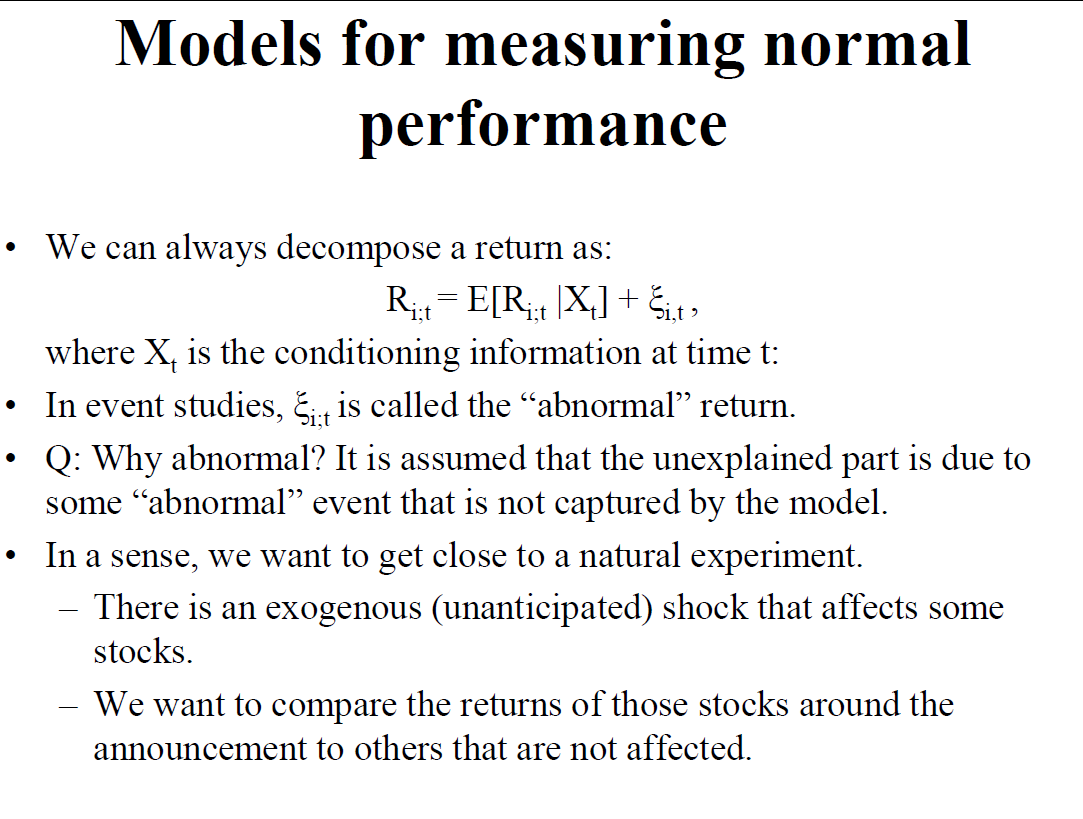

### Dates filtering

In [668]:
days_window=pd.Timedelta('20D')
days_window

Timedelta('20 days 00:00:00')

In [669]:
DOGE_ff5=pd.merge(pd.merge(DOGE,ff_factors_original, how='left', left_index=True, right_index=True), rf, how='left', left_index=True, right_index=True).ffill()
DOGE_ff5['DOGE-USD']=DOGE_ff5['DOGE-USD']-DOGE_ff5['RF']
DOGE_ff5=DOGE_ff5[DOGE_ff5.index<=event_dates['DOGE-USD'] + days_window]
DOGE_ff5

,DOGE-USD,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,
2020-05-07,0.053381,0.0133,0.0016,0.0039,-0.0017,-0.0069,0.0
2020-05-08,-0.014640,0.0190,0.0192,0.0248,0.0089,0.0039,0.0
2020-05-09,-0.004571,0.0190,0.0192,0.0248,0.0089,0.0039,0.0
2020-05-10,-0.058936,0.0190,0.0192,0.0248,0.0089,0.0039,0.0
2020-05-11,-0.018707,0.0007,-0.0023,-0.0375,-0.0082,-0.0006,0.0
...,...,...,...,...,...,...,...
2021-05-24,0.188564,0.0100,-0.0048,-0.0069,0.0026,-0.0032,0.0
2021-05-25,-0.054238,-0.0030,-0.0083,-0.0122,0.0022,-0.0018,0.0
2021-05-26,0.021343,0.0047,0.0180,0.0052,-0.0046,0.0015,0.0


<AxesSubplot:xlabel='Date'>

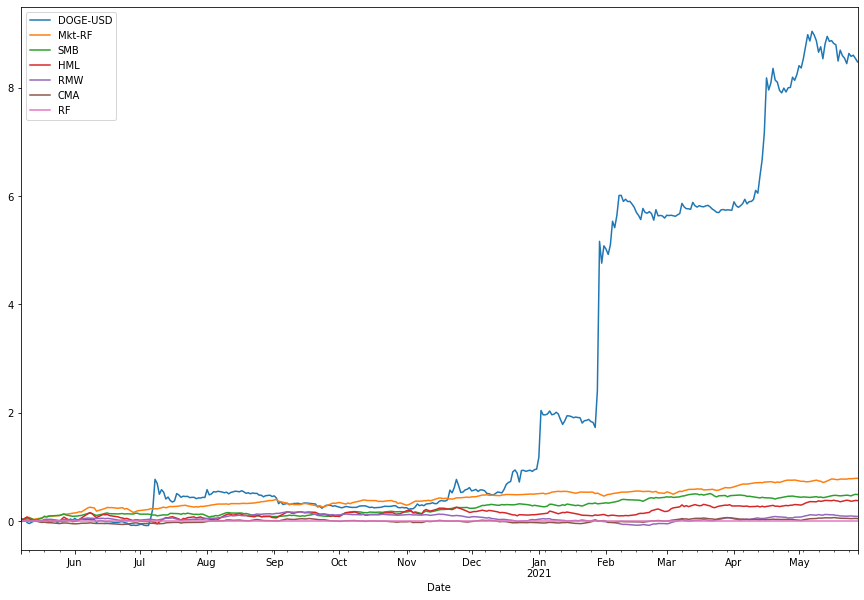

In [764]:
DOGE_ff5.cumsum().plot(figsize=(15,10))

In [671]:
GME_ff5=pd.merge(pd.merge(GME,ff_factors_original, how='inner', left_index=True, right_index=True), rf, how='inner', left_index=True, right_index=True).ffill()
GME_ff5['GME']=GME_ff5['GME']-GME_ff5['RF']
GME_ff5=GME_ff5[GME_ff5.index<=event_dates['GME'] + days_window]
GME_ff5

,GME,Mkt-RF,SMB,HML,RMW,CMA,RF
2020-01-22,-0.006596,0.0008,-0.0025,0.0000,-0.0026,0.0000,0.00006
2020-01-23,0.013098,0.0008,-0.0007,-0.0014,0.0026,-0.0004,0.00006
2020-01-24,-0.064995,-0.0097,-0.0048,-0.0032,0.0017,-0.0004,0.00006
2020-01-27,-0.009319,-0.0156,0.0026,-0.0042,-0.0058,0.0005,0.00006
2020-01-28,-0.016415,0.0102,-0.0015,-0.0043,0.0015,-0.0010,0.00006
2020-01-29,-0.019062,-0.0010,-0.0045,-0.0096,0.0025,0.0019,0.00006
2020-01-30,-0.048486,0.0034,-0.0063,0.0063,-0.0038,-0.0012,0.00006
2020-01-31,-0.022961,-0.0174,-0.0053,-0.0034,-0.0058,-0.0069,0.00006
2020-02-03,0.028586,0.0084,0.0036,-0.0071,-0.0074,-0.0035,0.00006
2020-02-04,0.030320,0.0157,-0.0012,-0.0067,0.0034,-0.0015,0.00006


<AxesSubplot:>

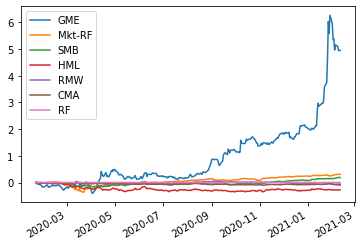

In [672]:
GME_ff5.cumsum().plot()

## Prediction models - OLS Linear Regression

https://www.statsmodels.org/stable/regression.html

### CAPM

In [673]:
DOGE_capm_model = sm.OLS(DOGE_ff5['DOGE-USD'], DOGE_ff5['Mkt-RF'])
DOGE_capm_results = DOGE_capm_model.fit()
print(DOGE_capm_results.summary())

                                 OLS Regression Results                                
Dep. Variable:               DOGE-USD   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.002
Method:                 Least Squares   F-statistic:                             0.1722
Date:                Fri, 30 Jul 2021   Prob (F-statistic):                       0.678
Time:                        16:41:22   Log-Likelihood:                          106.42
No. Observations:                 387   AIC:                                     -210.8
Df Residuals:                     386   BIC:                                     -206.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [674]:
GME_capm_model = sm.OLS(GME_ff5['GME'], GME_ff5['Mkt-RF'])
GME_capm_results = GME_capm_model.fit()
print(GME_capm_results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    GME   R-squared (uncentered):                   0.007
Model:                            OLS   Adj. R-squared (uncentered):              0.003
Method:                 Least Squares   F-statistic:                              1.874
Date:                Fri, 30 Jul 2021   Prob (F-statistic):                       0.172
Time:                        16:41:23   Log-Likelihood:                          126.01
No. Observations:                 268   AIC:                                     -250.0
Df Residuals:                     267   BIC:                                     -246.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### FF5

In [675]:
X=DOGE_ff5.iloc[:,1:-1]
X=sm.add_constant(X)
DOGE_ff5_model = sm.OLS(DOGE_ff5['DOGE-USD'], X)
DOGE_ff5_results = DOGE_ff5_model.fit()
print(DOGE_ff5_results.summary())

                            OLS Regression Results                            
Dep. Variable:               DOGE-USD   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.4623
Date:                Fri, 30 Jul 2021   Prob (F-statistic):              0.804
Time:                        16:41:23   Log-Likelihood:                 110.27
No. Observations:                 387   AIC:                            -208.5
Df Residuals:                     381   BIC:                            -184.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0226      0.010      2.374      0.0

In [676]:
X=GME_ff5.iloc[:,1:-1]
X=sm.add_constant(X)
GME_ff5_model = sm.OLS(GME_ff5['GME'], X)
GME_ff5_results = GME_ff5_model.fit()
print(GME_ff5_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    GME   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     13.67
Date:                Fri, 30 Jul 2021   Prob (F-statistic):           7.31e-12
Time:                        16:41:23   Log-Likelihood:                 158.13
No. Observations:                 268   AIC:                            -304.3
Df Residuals:                     262   BIC:                            -282.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0157      0.008      1.872      0.0

## AR abnormal returns

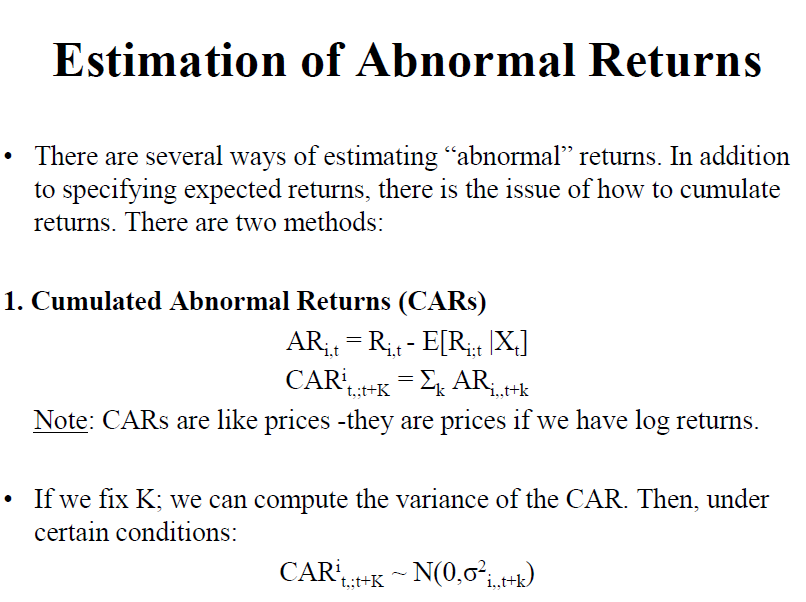

<AxesSubplot:xlabel='Date'>

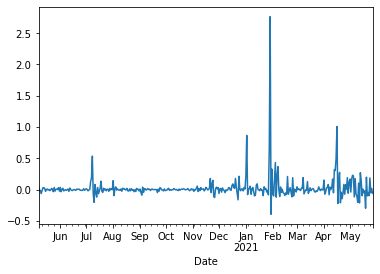

In [677]:
DOGE_capm_AR=DOGE_ff5['DOGE-USD'] - DOGE_capm_results.predict()
DOGE_capm_AR.plot()

<AxesSubplot:xlabel='Date'>

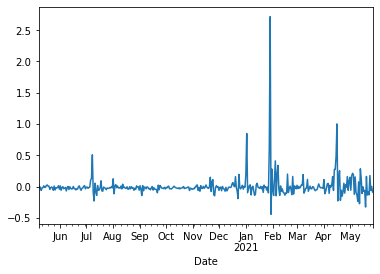

In [678]:
DOGE_ff5_model_AR=DOGE_ff5['DOGE-USD'] - DOGE_ff5_results.predict()
DOGE_ff5_model_AR.plot()

<AxesSubplot:>

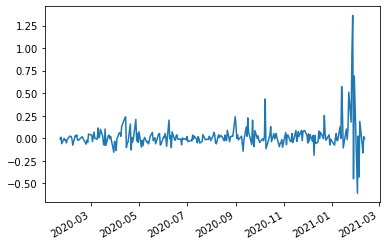

In [679]:
GME_capm_AR=GME_ff5['GME'] - GME_capm_results.predict()
GME_capm_AR.plot()

<AxesSubplot:>

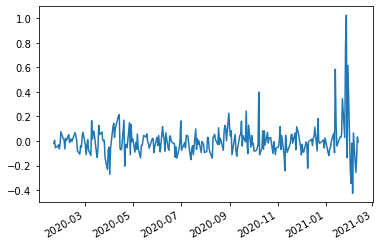

In [680]:
GME_ff5_model_AR=GME_ff5['GME'] - GME_ff5_results.predict()
GME_ff5_model_AR.plot()

## CAR - Cumulative Abnormal Returns

**DOGE**

In [751]:
days_window_DOGE=pd.Timedelta('11D')
days_window_DOGE

Timedelta('11 days 00:00:00')

In [761]:
DOGE_capm_AR=DOGE_capm_AR[(DOGE_capm_AR.index >= event_dates['DOGE-USD'] - days_window_DOGE) & (DOGE_capm_AR.index < event_dates['DOGE-USD'] + days_window_DOGE)]

<BarContainer object of 22 artists>

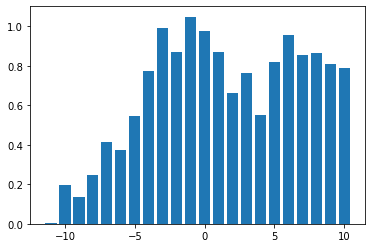

In [762]:
DOGE_capm_CAR=DOGE_capm_AR.cumsum()
DOGE_capm_CAR.index=list(range(-days_window_DOGE.days, days_window_DOGE.days))
matplotlib.pyplot.bar(DOGE_capm_CAR.index, DOGE_capm_CAR)

In [760]:
DOGE_ff5_model_AR=DOGE_ff5_model_AR[(DOGE_ff5_model_AR.index >= event_dates['DOGE-USD'] - days_window_DOGE) & (DOGE_ff5_model_AR.index < event_dates['DOGE-USD'] + days_window_DOGE)]

<BarContainer object of 22 artists>

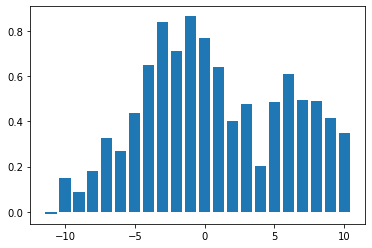

In [755]:
DOGE_ff5_model_CAR=DOGE_ff5_model_AR.cumsum()
DOGE_ff5_model_CAR.index=list(range(-days_window_DOGE.days, days_window_DOGE.days))
matplotlib.pyplot.bar(DOGE_ff5_model_CAR.index, DOGE_ff5_model_CAR)

**GME**

In [728]:
days_window_GME=pd.Timedelta('15D') #15D for -10 +10 windows
days_window_GME

Timedelta('15 days 00:00:00')

In [729]:
GME_capm_AR=GME_capm_AR[(GME_capm_AR.index >= event_dates['GME'] - days_window_GME) & (GME_capm_AR.index < event_dates['GME'] + days_window_GME)]
GME_capm_AR

2021-01-07   -0.025715
2021-01-08   -0.024603
2021-01-11    0.130223
2021-01-12   -0.001758
2021-01-13    0.573519
2021-01-14    0.271673
2021-01-15   -0.105385
2021-01-19    0.103263
2021-01-20   -0.013589
2021-01-21    0.100187
2021-01-22    0.511223
2021-01-25    0.179479
2021-01-26    0.928976
2021-01-27    1.363400
2021-01-28   -0.448364
2021-01-29    0.689659
2021-02-01   -0.317978
2021-02-02   -0.608799
2021-02-03    0.025886
2021-02-04   -0.428371
2021-02-05    0.188514
Name: GME, dtype: float64

In [733]:
GME_capm_CAR

2021-01-07   -0.025715
2021-01-08   -0.050318
2021-01-11    0.079905
2021-01-12    0.078147
2021-01-13    0.651666
2021-01-14    0.923339
2021-01-15    0.817953
2021-01-19    0.921216
2021-01-20    0.907627
2021-01-21    1.007814
2021-01-22    1.519036
2021-01-25    1.698515
2021-01-26    2.627491
2021-01-27    3.990892
2021-01-28    3.542528
2021-01-29    4.232187
2021-02-01    3.914209
2021-02-02    3.305409
2021-02-03    3.331295
2021-02-04    2.902924
2021-02-05    3.091438
Name: GME, dtype: float64

<BarContainer object of 21 artists>

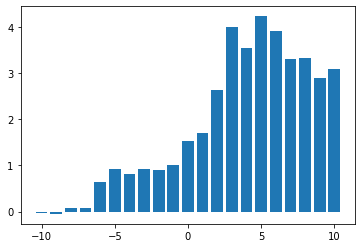

In [739]:
GME_capm_CAR=GME_capm_AR.cumsum()
GME_capm_CAR.index=list(range(-int((GME_capm_AR.shape[0]-1)/2), int((GME_capm_AR.shape[0]-1)/2)+1))
matplotlib.pyplot.bar(GME_capm_CAR.index, GME_capm_CAR)

In [740]:
GME_ff5_model_AR=GME_ff5_model_AR[(GME_ff5_model_AR.index >= event_dates['GME'] - days_window_GME) & (GME_ff5_model_AR.index < event_dates['GME'] + days_window_GME)]
GME_ff5_model_AR

2021-01-07   -0.052791
2021-01-08    0.000027
2021-01-11    0.063403
2021-01-12   -0.095992
2021-01-13    0.584681
2021-01-14    0.143664
2021-01-15   -0.042094
2021-01-19    0.032265
2021-01-20    0.030821
2021-01-21    0.051751
2021-01-22    0.345467
2021-01-25    0.027543
2021-01-26    0.785112
2021-01-27    1.023921
2021-01-28   -0.135672
2021-01-29    0.616042
2021-02-01   -0.225379
2021-02-02   -0.346402
2021-02-03   -0.018261
2021-02-04   -0.425991
2021-02-05    0.065673
Name: GME, dtype: float64

<BarContainer object of 21 artists>

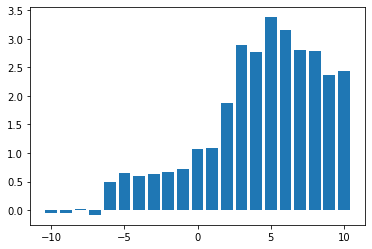

In [741]:
GME_ff5_model_CAR=GME_ff5_model_AR.cumsum()
GME_ff5_model_CAR.index=list(range(-int((GME_ff5_model_AR.shape[0]-1)/2), int((GME_ff5_model_AR.shape[0]-1)/2)+1))
matplotlib.pyplot.bar(GME_ff5_model_CAR.index, GME_ff5_model_CAR)

## BHAR - Buy and Hold Abnormal Returns

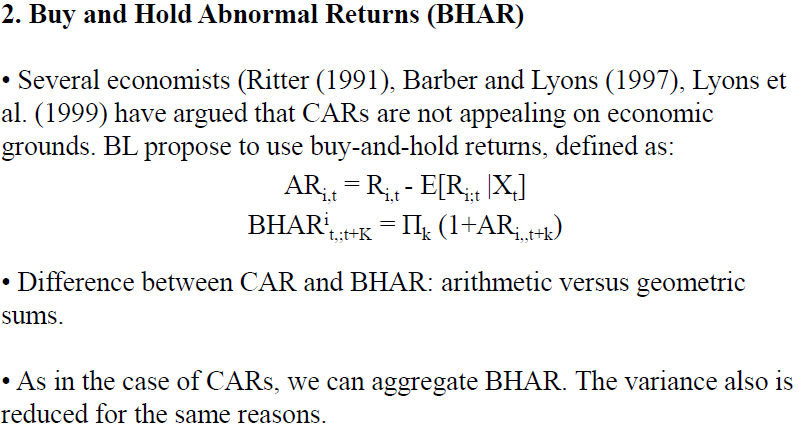

**DOGE**

<BarContainer object of 22 artists>

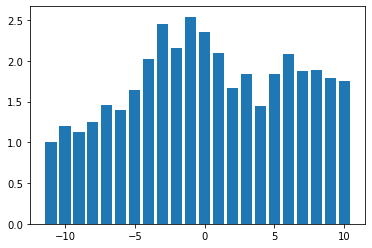

In [756]:
DOGE_capm_BHAR=DOGE_capm_AR.add(1).cumprod()
DOGE_capm_BHAR.index=list(range(-days_window_DOGE.days, days_window_DOGE.days))
matplotlib.pyplot.bar(DOGE_capm_BHAR.index, DOGE_capm_BHAR)

<BarContainer object of 22 artists>

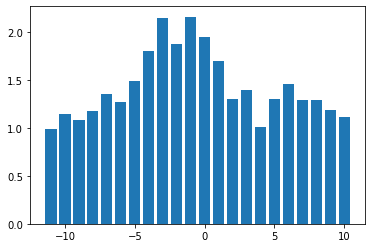

In [757]:
DOGE_ff5_model_BHAR=DOGE_ff5_model_AR.add(1).cumprod()
DOGE_ff5_model_BHAR.index=list(range(-days_window_DOGE.days, days_window_DOGE.days))
matplotlib.pyplot.bar(DOGE_ff5_model_BHAR.index, DOGE_ff5_model_BHAR)

**GME**

<BarContainer object of 21 artists>

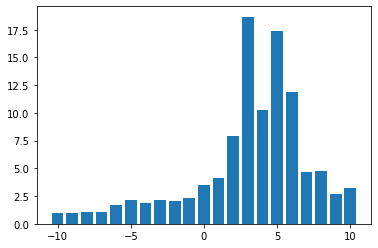

In [758]:
GME_capm_BHAR=GME_capm_AR.add(1).cumprod()
GME_capm_BHAR.index=list(range(-int((GME_capm_AR.shape[0]-1)/2), int((GME_capm_AR.shape[0]-1)/2)+1))
matplotlib.pyplot.bar(GME_capm_BHAR.index, GME_capm_BHAR)

<BarContainer object of 21 artists>

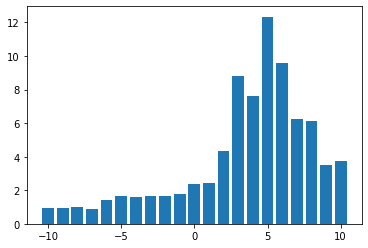

In [759]:
GME_ff5_model_BHAR=GME_ff5_model_AR.add(1).cumprod()
GME_ff5_model_BHAR.index=list(range(-int((GME_ff5_model_AR.shape[0]-1)/2), int((GME_ff5_model_AR.shape[0]-1)/2)+1))
matplotlib.pyplot.bar(GME_ff5_model_BHAR.index, GME_ff5_model_BHAR)

## T-test: H0: the event has no impact on the asset prices (CAR or BHAR mean=0)

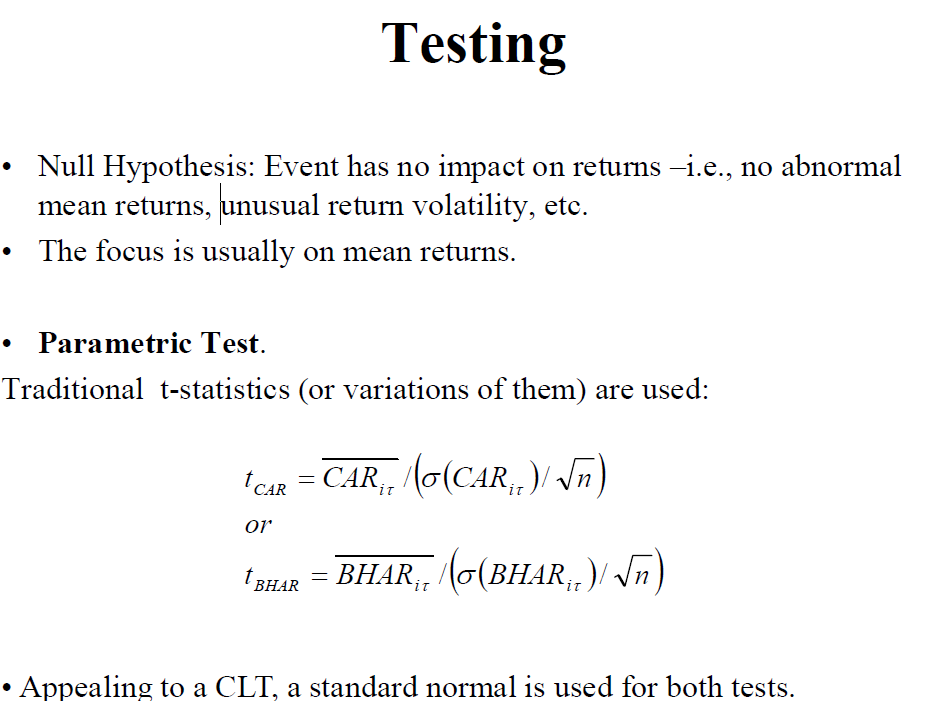

# References

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
- https://www.eventstudytools.com/significance-tests#t-test
- https://ebrary.net/732/business_finance/market_efficiency